In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# mount dataset folder
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    base_path = '/content/drive/My Drive/Colab Notebooks/ML_sound_classification_project'
else:
    base_path = ""

# set train-tests paths
import os
train_path = os.path.join(base_path, 'FSDKaggle2018.audio_train')
train_labels_path = os.path.join(base_path, 'FSDKaggle2018.meta', 'train.csv')
test_path = os.path.join(base_path, 'FSDKaggle2018.audio_test')
test_labels_path = os.path.join(base_path, 'FSDKaggle2018.meta', 'test.csv')

In [0]:
import pandas as pd
import seaborn as sns
import wave
import librosa
import numpy as np
import scipy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import IPython.display as ipd  # to play sound in notebook

from keras import Sequential
from keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [9]:
train_df = pd.read_csv(train_labels_path)
test_df = pd.read_csv(test_labels_path)
train_df.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [6]:
fname = os.path.join(train_path, '0c7ae294.wav')   # Applause
# Open using wave library
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

ipd.Audio(fname)

Sampling (frame) rate =  44100
Total samples (frames) =  299880
Duration =  6.8


In [8]:
filtered_classes = ['Saxophone','Applause','Acoustic_guitar','Bark','Bass_drum','Cough','Fireworks','Laughter','Flute','Trumpet']
train_df_filtered = train_df[train_df["label"].isin(filtered_classes)]
test_df_filtered = test_df[test_df["label"].isin(filtered_classes)]

print("Number of training examples: %d"%(train_df_filtered.shape[0]))
print("Number of tesing examples: %d"%(test_df_filtered.shape[0]))
print("Number of Classes: %d"%(train_df_filtered.label.nunique()))
print("\nClasses: ",train_df_filtered.label.unique())

Number of training examples: 2882
Number of tesing examples: 435
Number of Classes: 10

Classes:  ['Saxophone' 'Trumpet' 'Laughter' 'Flute' 'Cough' 'Bark' 'Bass_drum'
 'Fireworks' 'Applause' 'Acoustic_guitar']


####  Building a Model using MFCC Features

#### simple data loader

In [0]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=10, 
                 learning_rate=0.0001, max_epochs=20, n_mfcc=40):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.n_mfcc = n_mfcc
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.audio_length = self.sampling_rate * self.audio_duration
        self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)

def prepare_data(fnames, config, data_dir):
    X = np.empty(shape=(len(fnames), config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
        file_path = os.path.join(data_dir, fname)
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

#### generator way

In [0]:
class DataGenerator(Sequence):
    def __init__(self, fnames, labels, base_path, batch_size=32, n_mfcc=40, 
                 n_classes=10, audio_duration=2, sampling_rate=44100, shuffle=True):
        self.data_ids = fnames
        self.labels = labels
        self.base_path = base_path
        self.batch_size = batch_size
        self.n_mfcc = n_mfcc
        self.n_classes = n_classes
        self.audio_duration = audio_duration
        self.sampling_rate = sampling_rate
        self.audio_length = audio_duration * self.sampling_rate
        self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indices after each epoch'
        self.indices = np.arange(len(self.data_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indices of the batch
        list_IDs_temp = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # Store class
        y = self.labels[list_IDs_temp]
        # Generate data
        for i, index in enumerate(list_IDs_temp):
            X[i,] = self.load_audio_dataset(index)
        X = X.reshape((*X.shape, 1))
        return X, to_categorical(y, num_classes=self.n_classes)

    def load_audio_dataset(self, index):
        'Load audio dataset'
        f = self.data_ids[index]
        file_path = os.path.join(self.base_path, f)
        data, _ = librosa.core.load(file_path, sr=self.sampling_rate, res_type='kaiser_fast')
        data = self.pad_dataset(data, self.audio_length)
        data = librosa.feature.mfcc(data, sr=self.sampling_rate, n_mfcc=self.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        print("Data shape: ",data.shape)
        return data
    
    def pad_dataset(self, data, audio_length):
        'Pad dataset if length less than audio_length'
        # random  padding / offset
        if len(data) > audio_length:
            max_offset = len(data) - audio_length
            offset = np.random.randint(max_offset)
            data = data[offset:(audio_length+offset)]
        # pad if data is smaller
        else:
            if audio_length > len(data):
                max_offset = audio_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, audio_length - len(data) - offset), "constant")
        return data

#### Model Setup - Conv1d

In [0]:
def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,4), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*2, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [0]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plots the confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(12,10))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Confusion Matrix");

def plot_loss(history):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()

#### Code

In [38]:
train_base_path = os.path.join(base_path, 'FSDKaggle2018.audio_train')
test_base_path = os.path.join(base_path, 'FSDKaggle2018.audio_test')

X_train_labels = np.array(train_df['label'])
encoder = LabelEncoder()
encoder.fit(X_train_labels)
X_train_fnames = np.array(train_df['fname'])
X_train_labels = encoder.transform(X_train_labels)

X_test_fnames = np.array(test_df['fname'])
X_test_labels = np.array(test_df['label'])
X_test_labels = encoder.transform(X_test_labels)

config = Config(sampling_rate=44100, audio_duration=2, learning_rate=0.0001, n_mfcc=40, n_classes=10)
X_train = prepare_data(X_train_fnames, config, train_base_path)
y_train = to_categorical(X_train_labels, num_classes=config.n_classes)

X_test = prepare_data(X_test_fnames, config, test_base_path)
y_test = to_categorical(X_test_labels, num_classes=config.n_classes)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

np.save(base_path + "/X_train_all.npy",X_train)
np.save(base_path + "/y_train_all.npy",y_train)
np.save(base_path + "/X_test_all.npy",X_test)
np.save(base_path + "/y_test_all.npy",y_test)

In [0]:
config = Config(sampling_rate=44100, audio_duration=2, learning_rate=0.001, n_mfcc=40, n_classes=10)
model = get_2d_conv_model(config)
# model.summary()

In [0]:
# Clear any logs from previous runs
!rm -rf '/content/drive/My Drive/Colab Notebooks/ML_sound_classification_project/logs/'
import datetime 
log_dir = os.path.join(base_path,'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
from keras.callbacks import TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, write_graph=True)

In [0]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=32,
                    callbacks=[tensorboard_callback],
                    epochs=40)

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir '/content/drive/My Drive/Colab Notebooks/ML_sound_classification_project/logs/'

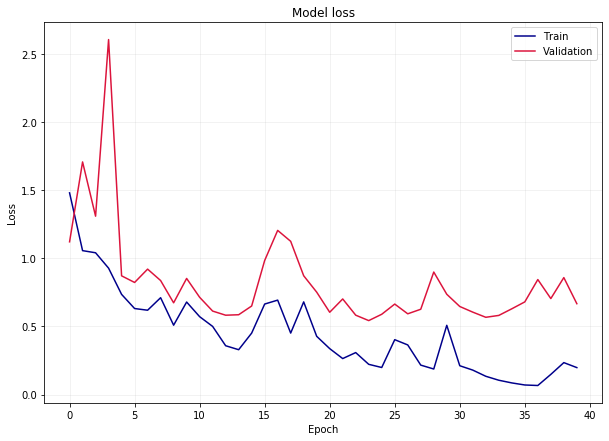

In [183]:
plot_loss(history)

In [157]:
y_pred_ = model.predict(X_test, use_multiprocessing=True, workers=6, verbose=1)

435/435 [==============================] - 1s 2ms/step


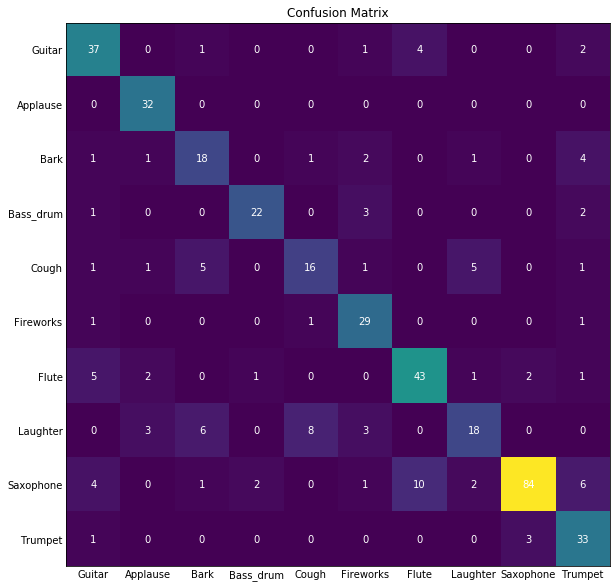

In [186]:
y_pred = np.argmax(y_pred_, axis=1)
y_true = np.argmax(y_test, axis=1)
labels = encoder.classes_
labels[0] = 'Guitar'
plot_confusion_matrix(y_true, y_pred, labels)

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [270]:
mnb = GaussianNB()
X_train_ = X_train.reshape(2882, 40*173)
clf = mnb.fit(X_train_, np.argmax(y_train, axis=1))
X_test_ = X_test.reshape(435, 40*173)
y_pred = clf.predict(X_test_)

print(( clf.predict(X_train.reshape(2882, 40*173)) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(X_test_.reshape(435, 40*173)) == np.argmax(y_test, axis=1)).sum() / len(y_test))

0.5544760582928522
0.5517241379310345


In [0]:
clf = LogisticRegression()
X_train_ = X_train.reshape(2882, 40*173)
clf = clf.fit(X_train_, np.argmax(y_train, axis=1))
X_test_ = X_test.reshape(435, 40*173)
y_pred = clf.predict(X_test_)

print(( clf.predict(X_train.reshape(2882, 40*173)) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(X_test_.reshape(435, 40*173)) == np.argmax(y_test, axis=1)).sum() / len(y_test))

In [273]:
clf = SGDClassifier(loss='hinge')
X_train_ = X_train.reshape(2882, 40*173)
clf = clf.fit(X_train_, np.argmax(y_train, axis=1))
X_test_ = X_test.reshape(435, 40*173)
y_pred = clf.predict(X_test_)

print(( clf.predict(X_train.reshape(2882, 40*173)) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(X_test_.reshape(435, 40*173)) == np.argmax(y_test, axis=1)).sum() / len(y_test))

0.9049271339347675
0.5494252873563218


['Cough'] 79faa0c4.wav
Sampling (frame) rate =  44100
Total samples (frames) =  891702
Duration =  20.22


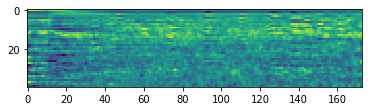

In [382]:
ind = 1345
print(encoder.inverse_transform([np.argmax(y_train[ind])]), train_df_filtered['fname'].iloc[ind])
plt.imshow(X_train[ind].reshape(X_train[0].shape[0], X_train[0].shape[1]))

fname = os.path.join(train_path, train_df_filtered['fname'].iloc[ind])   # Applause
# Open using wave library
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

ipd.Audio(fname)


(40, 871)


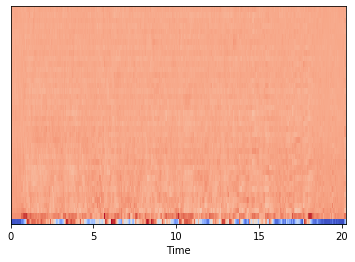

In [383]:
import librosa.display
import sklearn.preprocessing

x, fs = librosa.load(train_base_path + '/' + train_df_filtered['fname'].iloc[ind])
librosa.display.waveplot(x, sr=fs)

mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=40)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=fs, x_axis='time')

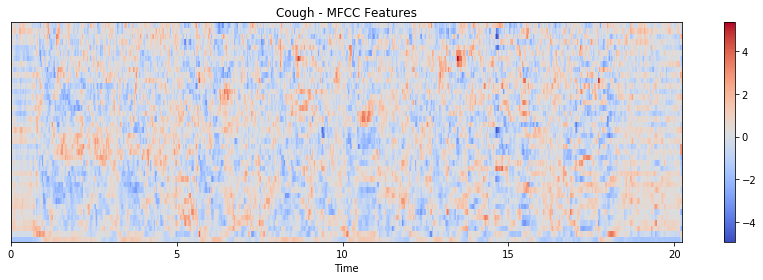

In [384]:
plt.figure(figsize=(12,4))
plt.title(encoder.inverse_transform([np.argmax(y_train[ind])])[0] + " - MFCC Features")
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.show()